Medium story [Demystify Agent Tool-Calling with the Llama 3 Model](https://medium.com/@yuxiaojian/demystify-agent-tool-calling-with-the-llama-3-model-b79b2db1655f)

The original code is from [tool-calling-agent-local](https://github.com/langchain-ai/langgraph/blob/main/examples/tutorials/tool-calling-agent-local.ipynb)


In [3]:
#%pip install -U langchain-ollama

In [4]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [5]:
_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
#os.environ["LANGCHAIN_TRACING_V2"] = "true"

OPENAI_API_KEY:  ········
TAVILY_API_KEY:  ········


In [7]:
# /// LLM ///

from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3-groq-tool-use",
    #model="llama3.1",
    temperature=0,
)

# /// Retriever tool ///

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings

from langchain.text_splitter import RecursiveCharacterTextSplitter

# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Add the document chunks to the "vector store" using OpenAIEmbeddings
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever(k=4)


# Define a tool, which we will connect to our agent
def retrieve_documents(query: str) -> list:
    """Retrieve documents from the vector store based on the query."""
    return retriever.invoke(query)


# /// Search Tool

from langchain_community.tools.tavily_search import TavilySearchResults

from langchain.schema import Document

web_search_tool = TavilySearchResults()


def web_search(query: str) -> str:
    """Run web search on the question."""
    web_results = web_search_tool.invoke({"query": query})
    return [
        Document(page_content=d["content"], metadata={"url": d["url"]})
        for d in web_results
    ]


# Tool list
tools = [retrieve_documents, web_search]

In [8]:
tools

[<function __main__.retrieve_documents(query: str) -> list>,
 <function __main__.web_search(query: str) -> str>]

In [9]:
from typing import Annotated, List

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.graph.message import AnyMessage, add_messages
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


class Assistant:
    def __init__(self, runnable: Runnable):
        """
        Initialize the Assistant with a runnable object.

        Args:
            runnable (Runnable): The runnable instance to invoke.
        """
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        """
        Call method to invoke the LLM and handle its responses.
        Re-prompt the assistant if the response is not a tool call or meaningful text.

        Args:
            state (State): The current state containing messages.
            config (RunnableConfig): The configuration for the runnable.

        Returns:
            dict: The final state containing the updated messages.
        """
        while True:
            result = self.runnable.invoke(state)  # Invoke the LLM
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Create the primary assistant prompt template
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant tasked with answering user questions. "
            "You have access to two tools: retrieve_documents and web_search. "
            "For any user questions about LLM agents, use the retrieve_documents tool to get information for a vectorstore. "
            "For any other questions, such as questions about current events, use the web_search tool to get information from the web. ",
        ),
        ("placeholder", "{messages}"),
    ]
)

# Prompt our LLM and bind tools
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

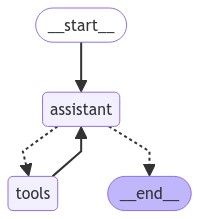

In [10]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state: State) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import tools_condition

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("assistant", Assistant(assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
memory = MemorySaver()
react_graph = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [14]:
import uuid


def predict_react_agent_answer(example: dict):
    """Use this for answer evaluation"""

    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    messages = react_graph.invoke({"messages": ("user", example["input"])}, config)
    return {"response": messages["messages"][-1].content, "messages": messages}


example = {"input": "Get me information about the the types of LLM agent memory?"}
response = predict_react_agent_answer(example)

See trace with llama3.1 here:

https://smith.langchain.com/public/44d0c7dd-a756-47ad-8025-ee7ae6469ecb/r

In [12]:
response

{'response': "The types of memory used in LLM-powered autonomous agents include short-term memory for storing temporary information and long-term memory for recording a comprehensive list of agents' experience.",
 'messages': {'messages': [HumanMessage(content='Get me information about the the types of LLM agent memory?', id='37c49213-e5ea-44fd-ab7b-086fe652506f'),
   AIMessage(content='', response_metadata={'model': 'llama3-groq-tool-use', 'created_at': '2024-08-23T11:27:32.653268Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'retrieve_documents', 'arguments': {'query': 'types of LLM agent memory'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 28186883849, 'load_duration': 4832608290, 'prompt_eval_count': 266, 'prompt_eval_duration': 18241422000, 'eval_count': 31, 'eval_duration': 5107596000}, id='run-1923115b-256b-47aa-a036-854c5af49278-0', tool_calls=[{'name': 'retrieve_documents', 'args': {'query': 'types of LLM agent memory'}

```bash
{
    'response': "The types of memory used in LLM-powered autonomous agents include short-term memory for storing temporary information and long-term memory for recording a comprehensive list of agents' experience.",
    'messages': {
        'messages': [
            HumanMessage(content='Get me information about the the types of LLM agent memory?', id='37c49213-e5ea-44fd-ab7b-086fe652506f'),
            AIMessage(content='', 
                      response_metadata={
                          'model': 'llama3-groq-tool-use',
                          'created_at': '2024-08-23T11:27:32.653268Z',
                          'message': {
                              'role': 'assistant',
                              'content': '',
                              'tool_calls': [{
                                  'function': {
                                      'name': 'retrieve_documents',
                                      'arguments': {'query': 'types of LLM agent memory'}
                                  }
                              }]
                          },
                          'done_reason': 'stop',
                          'done': True,
                          'total_duration': 28186883849,
                          'load_duration': 4832608290,
                          'prompt_eval_count': 266,
                          'prompt_eval_duration': 18241422000,
                          'eval_count': 31,
                          'eval_duration': 5107596000
                      },
                      id='run-1923115b-256b-47aa-a036-854c5af49278-0',
                      tool_calls=[{
                          'name': 'retrieve_documents',
                          'args': {'query': 'types of LLM agent memory'},
                          'id': '43427c37-677e-4649-9411-dee91568e540',
                          'type': 'tool_call'
                      }],
                      usage_metadata={
                          'input_tokens': 266,
                          'output_tokens': 31,
                          'total_tokens': 297
                      }),
            ToolMessage(content='[Document(...), Document(...), Document(...), Document(...)]',
                        name='retrieve_documents',
                        id='7900b747-d704-4e91-8c52-680fa7aabd1e',
                        tool_call_id='43427c37-677e-4649-9411-dee91568e540'),
            AIMessage(content="The types of memory used in LLM-powered autonomous agents include short-term memory for storing temporary information and long-term memory for recording a comprehensive list of agents' experience.",
                      response_metadata={
                          'model': 'llama3-groq-tool-use',
                          'created_at': '2024-08-23T11:29:31.337414Z',
                          'message': {
                              'role': 'assistant',
                              'content': "The types of memory used in LLM-powered autonomous agents include short-term memory for storing temporary information and long-term memory for recording a comprehensive list of agents' experience."
                          },
                          'done_reason': 'stop',
                          'done': True,
                          'total_duration': 118104554785,
                          'load_duration': 29778833,
                          'prompt_eval_count': 1946,
                          'prompt_eval_duration': 111978155000,
                          'eval_count': 34,
                          'eval_duration': 6073583000
                      },
                      id='run-84186411-ddbc-486c-9431-964a9b3d7037-0',
                      usage_metadata={
                          'input_tokens': 1946,
                          'output_tokens': 34,
                          'total_tokens': 1980
                      })
        ]
    }
}
```

In [15]:
example = {"input": "Get me information about the current weather in SF."}
response = predict_react_agent_answer(example)

See trace with llama3.1 here:

https://smith.langchain.com/public/7a4938e3-f94f-4e04-a162-bf592fba4643/r

In [16]:
response

{'response': "The current weather in SF is overcast with a temperature of 20.6°C (69.1°F). The wind speed is 4.3 mph (6.8 kph) from the south. There's no precipitation expected.",
 'messages': {'messages': [HumanMessage(content='Get me information about the current weather in SF.', id='ae016bcf-7152-40f9-82da-a937db338fd3'),
   AIMessage(content='', response_metadata={'model': 'llama3-groq-tool-use', 'created_at': '2024-08-23T18:59:31.644728Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'web_search', 'arguments': {'query': 'current weather in SF'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 5228904939, 'load_duration': 34775586, 'prompt_eval_count': 263, 'prompt_eval_duration': 665193000, 'eval_count': 29, 'eval_duration': 4525706000}, id='run-83632074-333c-426d-a401-7206bac6f654-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'current weather in SF'}, 'id': 'acb74c42-8b6e-47e7-83eb-b640ae113038', 'type': 'tool_call'}],

```
{
    'response': "The current weather in SF is overcast with a temperature of 20.6°C (69.1°F). The wind speed is 4.3 mph (6.8 kph) from the south. There's no precipitation expected.",
    'messages': {
        'messages': [
            HumanMessage(content='Get me information about the current weather in SF.', id='ae016bcf-7152-40f9-82da-a937db338fd3'),
            AIMessage(content='', 
                      response_metadata={
                          'model': 'llama3-groq-tool-use',
                          'created_at': '2024-08-23T18:59:31.644728Z',
                          'message': {
                              'role': 'assistant',
                              'content': '',
                              'tool_calls': [{
                                  'function': {
                                      'name': 'web_search',
                                      'arguments': {'query': 'current weather in SF'}
                                  }
                              }]
                          },
                          'done_reason': 'stop',
                          'done': True,
                          'total_duration': 5228904939,
                          'load_duration': 34775586,
                          'prompt_eval_count': 263,
                          'prompt_eval_duration': 665193000,
                          'eval_count': 29,
                          'eval_duration': 4525706000
                      },
                      id='run-83632074-333c-426d-a401-7206bac6f654-0',
                      tool_calls=[{
                          'name': 'web_search',
                          'args': {'query': 'current weather in SF'},
                          'id': 'acb74c42-8b6e-47e7-83eb-b640ae113038',
                          'type': 'tool_call'
                      }],
                      usage_metadata={
                          'input_tokens': 263,
                          'output_tokens': 29,
                          'total_tokens': 292
                      }),
            ToolMessage(content='[Document(...), Document(...), Document(...), Document(...), Document(...)]',
                        name='web_search',
                        id='e7fbb5f4-9fd1-49d9-a6b6-01271d7bc40c',
                        tool_call_id='acb74c42-8b6e-47e7-83eb-b640ae113038'),
            AIMessage(content="The current weather in SF is overcast with a temperature of 20.6°C (69.1°F). The wind speed is 4.3 mph (6.8 kph) from the south. There's no precipitation expected.",
                      response_metadata={
                          'model': 'llama3-groq-tool-use',
                          'created_at': '2024-08-23T19:01:02.402167Z',
                          'message': {
                              'role': 'assistant',
                              'content': "The current weather in SF is overcast with a temperature of 20.6°C (69.1°F). The wind speed is 4.3 mph (6.8 kph) from the south. There's no precipitation expected."
                          },
                          'done_reason': 'stop',
                          'done': True,
                          'total_duration': 85668739924,
                          'load_duration': 31249527,
                          'prompt_eval_count': 1510,
                          'prompt_eval_duration': 77401397000,
                          'eval_count': 50,
                          'eval_duration': 8219735000
                      },
                      id='run-64b9c994-5883-4e40-a946-876fe6d89d10-0',
                      usage_metadata={
                          'input_tokens': 1510,
                          'output_tokens': 50,
                          'total_tokens': 1560
                      })
        ]
    }
}

```